In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from statsmodels.formula.api import ols

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
aa = "A01"
#aa = "A02"
#aa = "A03"
#aa = "A04"
#aa = "A05"
#aa = "A06"
A0=pd.read_csv(aa+".csv",encoding="utf-8-sig")

In [3]:
A0["de_dt"] = pd.to_datetime(A0["de_dt"].astype(int).astype(str))
A0

,cust,pd_c,cop_c,de_dt,de_hr,buy_am,ma_fem_dv,ages,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M430112881,PD0290,A01,2021-01-01,10,15000.0,여성,50대,남성티셔츠,남성의류,남성의류상의
1,M646853852,PD1369,A01,2021-01-01,10,79700.0,여성,40대,기타주방일회용품,주방잡화,주방일회용품
2,M430112881,PD0290,A01,2021-01-01,10,19000.0,여성,50대,남성티셔츠,남성의류,남성의류상의
3,M430112881,PD0290,A01,2021-01-01,10,19000.0,여성,50대,남성티셔츠,남성의류,남성의류상의
4,M430112881,PD0290,A01,2021-01-01,10,19000.0,여성,50대,남성티셔츠,남성의류,남성의류상의
...,...,...,...,...,...,...,...,...,...,...,...
700840,M124216142,PD0288,A01,2021-12-31,20,54000.0,여성,40대,임대매출,기타(비상품),임대매출
700841,M941473755,PD0288,A01,2021-12-31,20,19800.0,남성,50대,임대매출,기타(비상품),임대매출
700842,M380362011,PD0776,A01,2021-12-31,21,5410.0,남성,20대,남성등산/아웃도어세트,스포츠패션,남성등산/아웃도어의류
700843,M380362011,PD0776,A01,2021-12-31,21,3950.0,남성,20대,남성등산/아웃도어세트,스포츠패션,남성등산/아웃도어의류


# 전처리

## 점수 base 생성

In [4]:
#raitings : 고객 별 상품 구매 횟수 count (대분류는 덤으로!)
A0_tmp = A0.value_counts(['cust','pd_c',"de_dt","clac_mcls_nm","clac_hlv_nm"]).reset_index().rename(columns={0:"buy_am"})
ratings=A0_tmp.groupby(['cust','pd_c',"clac_mcls_nm","clac_hlv_nm"],as_index=False).count()[['cust','pd_c',"clac_mcls_nm","clac_hlv_nm",'buy_am']]
ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am
0,M000034966,PD0777,남성스포츠화,스포츠패션,1
1,M000034966,PD0796,스포츠잡화,스포츠패션,1
2,M000034966,PD0816,여성스포츠화,스포츠패션,1
3,M000136117,PD0173,국산과일,과일,1
4,M000136117,PD0290,남성의류상의,남성의류,1
...,...,...,...,...,...
295092,M999962961,PD1683,식당,테넌트/음식점,1
295093,M999962961,PD1699,푸드코트,테넌트/음식점,1
295094,M999962961,PD1764,여성가방,패션잡화,2
295095,M999962961,PD1889,메이크업,화장품/뷰티케어,1


In [5]:
#고객 별 상품 대분류 별 구매 횟수
tmp = A0_tmp.groupby(['cust','clac_hlv_nm'],as_index=False).count()[['cust','clac_hlv_nm','buy_am']]
tmp

,cust,clac_hlv_nm,buy_am
0,M000034966,스포츠패션,3
1,M000136117,과일,1
2,M000136117,남성의류,5
3,M000136117,대용식,1
4,M000136117,모바일,1
...,...,...,...
153712,M999962961,조미료,1
153713,M999962961,커피/차,4
153714,M999962961,테넌트/음식점,2
153715,M999962961,패션잡화,2


In [6]:
#고객 별 구매 횟수
tmp_ref = A0_tmp.groupby("cust",as_index=False).sum()[["cust","buy_am"]].rename(columns={"buy_am":"buy_sum"})
tmp_ref

,cust,buy_sum
0,M000034966,4
1,M000136117,89
2,M000225114,156
3,M000261625,67
4,M000350564,32
...,...,...
20272,M999599111,1
20273,M999673157,12
20274,M999770689,22
20275,M999849895,24


In [7]:
#참조1 : 고객 별 대분류 구매 비율 생성

ref1 = pd.merge(tmp,tmp_ref, how='left',on='cust')
ref1["buy_score_ref"] = ref1["buy_am"]/ref1["buy_sum"]
ref1 = ref1.drop(["buy_am","buy_sum"],axis=1)
ref1

,cust,clac_hlv_nm,buy_score_ref
0,M000034966,스포츠패션,0.750000
1,M000136117,과일,0.011236
2,M000136117,남성의류,0.056180
3,M000136117,대용식,0.011236
4,M000136117,모바일,0.011236
...,...,...,...
153712,M999962961,조미료,0.023810
153713,M999962961,커피/차,0.095238
153714,M999962961,테넌트/음식점,0.047619
153715,M999962961,패션잡화,0.047619


In [8]:
#참조2 : 고객 별 상품 별 마지막 구매 날짜
score_update=A0_tmp.value_counts(['cust','pd_c','de_dt']).reset_index()[['cust','pd_c','de_dt']]
ref2 = score_update.groupby(["cust","pd_c"],as_index=False).max("de_dt").rename(columns={"de_dt":"last_dt"})
ref2

,cust,pd_c,last_dt
0,M000034966,PD0777,2021-01-16
1,M000034966,PD0796,2021-01-16
2,M000034966,PD0816,2021-01-16
3,M000136117,PD0173,2021-08-05
4,M000136117,PD0290,2021-07-25
...,...,...,...
295092,M999962961,PD1683,2021-06-18
295093,M999962961,PD1699,2021-06-25
295094,M999962961,PD1764,2021-10-22
295095,M999962961,PD1889,2021-06-13


In [9]:
#참조3 : 상품 별 고객 마다의 구매 간격들 평균 

tmp = A0_tmp.value_counts(['cust','pd_c','de_dt'])
date_file = tmp.reset_index()[['cust','pd_c','de_dt']]

qq = date_file.value_counts(["cust","pd_c"])[date_file.value_counts(["cust","pd_c"]) > 1].reset_index()[['cust','pd_c']]
qq

range_lst = []
for n in tqdm_notebook(range(len(qq))):
    i = qq.loc[n,"cust"]
    j = qq.loc[n,"pd_c"]
    tmp = date_file[(date_file["pd_c"] == j)&(date_file["cust"] == i)].sort_values("de_dt")
    for k in range(len(tmp)-1):
        range_lst.append({"pd_c":j,"range_mean":(tmp.iloc[k+1,2] - tmp.iloc[k,2]).days})
range_lst = pd.DataFrame(range_lst)

ref3 = range_lst.groupby("pd_c",as_index=False).mean("range_mean")[["pd_c","range_mean"]]

<ipython-input-9-5d7e158bef0e>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(qq))):


  0%|          | 0/86462 [00:00<?, ?it/s]

In [10]:
#합쳐주기!
ratings = pd.merge(ratings,ref1, how='left',on=['cust',"clac_hlv_nm"])
ratings = pd.merge(ratings,ref2, how='left',on=['cust',"pd_c"])
ratings = pd.merge(ratings,ref3, how='left',on='pd_c')
ratings = ratings.fillna(0)

ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am,buy_score_ref,last_dt,range_mean
0,M000034966,PD0777,남성스포츠화,스포츠패션,1,0.750000,2021-01-16,66.836585
1,M000034966,PD0796,스포츠잡화,스포츠패션,1,0.750000,2021-01-16,79.333333
2,M000034966,PD0816,여성스포츠화,스포츠패션,1,0.750000,2021-01-16,84.255663
3,M000136117,PD0173,국산과일,과일,1,0.011236,2021-08-05,17.942857
4,M000136117,PD0290,남성의류상의,남성의류,1,0.056180,2021-07-25,69.655152
...,...,...,...,...,...,...,...,...
295092,M999962961,PD1683,식당,테넌트/음식점,1,0.047619,2021-06-18,48.405242
295093,M999962961,PD1699,푸드코트,테넌트/음식점,1,0.047619,2021-06-25,51.563450
295094,M999962961,PD1764,여성가방,패션잡화,2,0.047619,2021-10-22,57.283871
295095,M999962961,PD1889,메이크업,화장품/뷰티케어,1,0.047619,2021-06-13,95.341584


## 점수체계

In [11]:
#구매 횟수 0~5점
ratings['buy_level']=np.where(ratings.buy_am>=24,5,
                       np.where(ratings.buy_am>=12,4,
                               np.where(ratings.buy_am>=6,3,
                                       np.where(ratings.buy_am>=4,2,
                                               np.where(ratings.buy_am>=3,1,0)))))

ratings['buy_level']=ratings['buy_level'].astype('float')

In [12]:
#대분류 0~5점

low_clac_lst = A0_tmp.value_counts(["cust","clac_hlv_nm"]).reset_index().rename(columns={0:"count"}).groupby("clac_hlv_nm",as_index=False).mean("count")[["clac_hlv_nm","count"]]

low_clac_lst["low_clac"] = np.where(low_clac_lst["count"] >= low_clac_lst["count"].quantile(q=15/21),5,
                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=10/21),4,
                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=6/21),3,
                                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=3/21),2,
                                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=1/21),1,0)))))


ratings = pd.merge(ratings, low_clac_lst.drop("count",axis=1), how='left',on = 'clac_hlv_nm')

In [13]:
#(구매 간격 / 평균 구매 간격)의 quantile 별 점수

##range_mean이 0인 애들의 대체값, 같은 대분류들 중 최대 구매간격
tmp_value = ratings[ratings["range_mean"] == 0].value_counts("clac_hlv_nm").reset_index().drop(0,axis=1)
tmp_m = []
for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):
    tmp_m.append(ratings[(ratings["clac_hlv_nm"] == i) & (ratings["range_mean"] != 0)]["range_mean"].max())
tmp_value["tmp_m"] = tmp_m

ratings = pd.merge(ratings, tmp_value, how='left',on="clac_hlv_nm")
ratings.loc[ratings["range_mean"] != 0,"tmp_m"] = 0
ratings["tmp_m"] = ratings["tmp_m"].fillna(ratings["range_mean"].max())

today = pd.datetime(year = 2022, month = 1, day = 1)
ratings["range_result"] = (today - ratings["last_dt"]).dt.days / (ratings["range_mean"] + ratings["tmp_m"])


ratings["range_score"] = np.where(ratings["range_result"] >= ratings["range_result"].quantile(q=15/21),5,
                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=10/21),4,
                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=6/21),3,
                                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=3/21),2,
                                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=1/21),1,0)))))

<ipython-input-13-2b9e33574f74>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):


  0%|          | 0/54 [00:00<?, ?it/s]

<ipython-input-13-2b9e33574f74>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime(year = 2022, month = 1, day = 1)


### 비율 확인

(array([254003.,      0.,  17064.,      0.,  12892.,      0.,   8506.,
             0.,   2100.,      0.,    532.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <BarContainer object of 11 artists>)

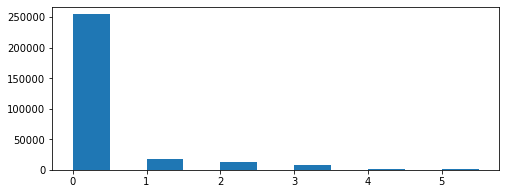

In [50]:
plt.figure(figsize=(8,3))

plt.hist(ratings["buy_level"], bins = np.arange(0,6,0.5))

(array([   916.,      0.,   3512.,      0.,  11998.,      0.,  12741.,
             0.,  34613.,      0., 231317.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <BarContainer object of 11 artists>)

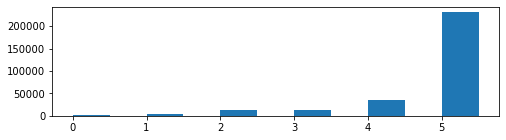

In [56]:
plt.figure(figsize=(8,2))
plt.hist(ratings["low_clac"], bins = np.arange(0,6,0.5))

(array([14053.,     0., 28096.,     0., 42165.,     0., 56208.,     0.,
        70252.,     0., 84323.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <BarContainer object of 11 artists>)

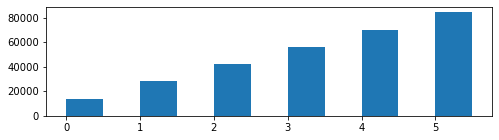

In [55]:
plt.figure(figsize=(8,2))
plt.hist(ratings["range_score"], bins = np.arange(0,6,0.5))

In [17]:
ratings["score"] = (ratings["buy_level"]*2 + ratings["low_clac"] + ratings["range_score"])/4

(array([   267.,   2624.,  18773.,  64961., 115460.,  76355.,  11089.,
          4497.,    943.,    128.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

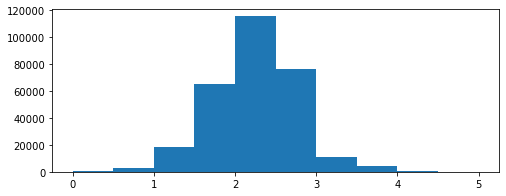

In [60]:
plt.figure(figsize=(8,3))
plt.hist(ratings["score"], bins = np.arange(0,5.5,0.5))

# 모델링

## LabelEncoding

In [19]:
le_c = LabelEncoder()
le_c = le_c.fit(ratings.cust)
ratings['cust']=le_c.transform(ratings.cust)
customer_info=pd.DataFrame(le_c.classes_, columns={'cust'})
customer_info['label']=range(0,len(ratings.cust.unique()))
customer_info.to_csv(aa+"_customer_info.csv",index=False)
customer_info

,cust,label
0,M000034966,0
1,M000136117,1
2,M000225114,2
3,M000261625,3
4,M000350564,4
...,...,...
20272,M999599111,20272
20273,M999673157,20273
20274,M999770689,20274
20275,M999849895,20275


In [20]:
le_p = LabelEncoder()
le_p = le_p.fit(ratings.pd_c)
ratings['pd_c']=le_p.transform(ratings.pd_c)
pd_info=pd.DataFrame(le_p.classes_, columns={'pd_c'})
pd_info['label']=range(0,len(ratings.pd_c.unique()))
pd_info.to_csv(aa+"_pd_info.csv",index=False)
pd_info

,pd_c,label
0,PD0001,0
1,PD0002,1
2,PD0003,2
3,PD0004,3
4,PD0005,4
...,...,...
1460,PD1929,1460
1461,PD1930,1461
1462,PD1931,1462
1463,PD1932,1463


In [21]:
# train test 분리
TRAIN_SIZE = 0.9
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [22]:
users=A0.groupby(['cust','ages','ma_fem_dv'],as_index=False).count()
users=users[['cust','ages','ma_fem_dv']]
users['cust']=le_c.transform(users.cust)
users

,cust,ages,ma_fem_dv
0,0,40대,여성
1,1,30대,여성
2,2,40대,여성
3,3,40대,여성
4,4,60대,여성
...,...,...,...
20272,20272,40대,여성
20273,20273,30대,남성
20274,20274,30대,여성
20275,20275,20대,여성


In [23]:
ages=[]
for i in range(len(users)):
    users.ages[i]=users.ages[i][0:2]
users.ages=users.ages.astype('float')

<ipython-input-23-ab29fe5432dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.ages[i]=users.ages[i][0:2]


In [24]:
le_s = LabelEncoder()
le_s = le_s.fit(users.ma_fem_dv)
users['ma_fem_dv']=le_s.transform(users.ma_fem_dv)

customer_info['sex']=users['ma_fem_dv']
customer_info

,cust,label,sex
0,M000034966,0,1
1,M000136117,1,1
2,M000225114,2,1
3,M000261625,3,1
4,M000350564,4,1
...,...,...,...
20272,M999599111,20272,1
20273,M999673157,20273,0
20274,M999770689,20274,1
20275,M999849895,20275,1


In [63]:
users

,cust,ages,ma_fem_dv
0,0,40.0,1
1,1,30.0,1
2,2,40.0,1
3,3,40.0,1
4,4,60.0,1
...,...,...,...
20272,20272,40.0,1
20273,20273,30.0,0
20274,20274,30.0,1
20275,20275,20.0,1


In [26]:
L=len(customer_info)
train_asz = pd.merge(ratings_train, users, on='cust')[['ages','ma_fem_dv']]
test_asz = pd.merge(ratings_test, users, on='cust')[['ages','ma_fem_dv']]

## INPUT file (구매 경험이 없는 고객-상품 모음) 생성

In [27]:
ratings = pd.merge(ratings,users,how="left",on="cust")

#회귀분석을 이용한 score 관련 변수 확인하기
res = ols('score ~ ages+ma_fem_dv', data=ratings).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     67.89
Date:                Sun, 07 Aug 2022   Prob (F-statistic):           3.34e-30
Time:                        01:45:55   Log-Likelihood:            -2.2149e+05
No. Observations:              295097   AIC:                         4.430e+05
Df Residuals:                  295094   BIC:                         4.430e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0784      0.004    532.524      0.000       2.071       2.086
ages           0.0010    8.6e-05     11.472      0.000       0.001       0.001
ma_fem_dv      0.0040      0.002      1.831      0.067      -0.000       0.008
==============================================================================
Omnibus:                     9038.356   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21984.521
Skew:                           0.131   Prob(JB):                         0.00
Kurtosis:                       4.311   Cond. No.                         177.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
ratings.to_csv(aa+"_ratings.csv",index=False,encoding='utf-8-sig')
users.to_csv(aa+"_users.csv",index=False)

In [29]:
check = np.zeros(shape=(len(ratings["cust"].unique()), len(ratings["pd_c"].unique())), dtype=np.int8) - 999


for i in tqdm_notebook(range(len(ratings))):
    c_label = ratings.iloc[i,0]
    p_label = ratings.iloc[i,1]
    sco = ratings.iloc[i,-1]
    check[int(c_label)][int(p_label)] = sco
    
cust = np.where(check == -999)[0]
pd_c = np.where(check == -999)[1]
last = pd.DataFrame()
last["cust"] = cust
last["pd_c"] = pd_c
last = pd.merge(last,users,how="left",on="cust")
last.to_csv(aa+"_input.csv",index=False)

<ipython-input-29-ee852db894de>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings))):


  0%|          | 0/295097 [00:00<?, ?it/s]

## Model Fitting

In [30]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.score.mean()    # 전체 평균 
M = ratings.cust.max() + 1       
N = ratings.pd_c.max() + 1  

In [31]:
# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [32]:
# Concatenate layers
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

In [33]:
age = Input(shape=(1, ))
age_embedding = Embedding(L, 3, embeddings_regularizer=l2())(age)
age_layer = Flatten()(age_embedding)

sex = Input(shape=(1, ))
sex_embedding = Embedding(L, 3, embeddings_regularizer=l2())(sex)
sex_layer = Flatten()(sex_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, age_layer,sex_layer])

In [34]:
# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('relu')(R)
R = Dense(1)(R)

In [35]:
model = Model(inputs=[user, item, age, sex], outputs=R)
model.compile(
  loss="mse",
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RootMeanSquaredError()]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [36]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=3),
             ModelCheckpoint(filepath=aa+'_best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [37]:
# Model fitting
result = model.fit(
  x=[ratings_train.cust.values, ratings_train.pd_c.values, train_asz.ages, train_asz.ma_fem_dv],
  y=ratings_train.score.values - mu,
  epochs=1000,
  batch_size=512,
  validation_data=(
    [ratings_test.cust.values, ratings_test.pd_c.values, test_asz.ages, test_asz.ma_fem_dv],
    ratings_test.score.values - mu
  ), callbacks = callbacks
)

Epoch 1/1000
519/519 [==============================] - 21s 38ms/step - loss: 34.0650 - root_mean_squared_error: 0.5112 - val_loss: 30.6648 - val_root_mean_squared_error: 0.5065
Epoch 2/1000
519/519 [==============================] - 20s 39ms/step - loss: 27.7241 - root_mean_squared_error: 0.5079 - val_loss: 24.9603 - val_root_mean_squared_error: 0.5029
Epoch 3/1000
519/519 [==============================] - 21s 40ms/step - loss: 22.5705 - root_mean_squared_error: 0.5035 - val_loss: 20.3232 - val_root_mean_squared_error: 0.4976
Epoch 4/1000
519/519 [==============================] - 21s 40ms/step - loss: 18.3805 - root_mean_squared_error: 0.4970 - val_loss: 16.5527 - val_root_mean_squared_error: 0.4901
Epoch 5/1000
519/519 [==============================] - 21s 40ms/step - loss: 14.9732 - root_mean_squared_error: 0.4884 - val_loss: 13.4864 - val_root_mean_squared_error: 0.4807
Epoch 6/1000
519/519 [==============================] - 21s 40ms/step - loss: 12.2030 - root_mean_squared_erro

## 결과 확인

In [38]:
keras_model_best = load_model(aa+'_best_model.h5')

<Figure size 576x576 with 0 Axes>

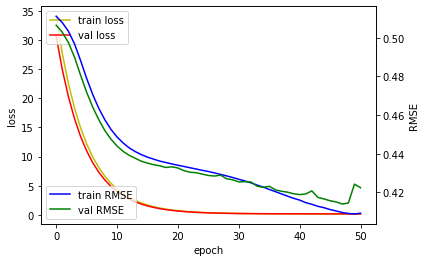

In [39]:
# Plot RMSE
plt.figure(figsize=(8,8))

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(result.history['loss'], 'y', label = 'train loss')
loss_ax.plot(result.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(result.history['root_mean_squared_error'], 'b', label = 'train RMSE')
acc_ax.plot(result.history['val_root_mean_squared_error'], 'g', label = 'val RMSE')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('RMSE')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.savefig(aa+'_model_loss.png')

In [40]:
# Prediction
user_ids = ratings_test.cust.values[100:110]
pd_ids = ratings_test.pd_c.values[100:110]
user_test = test_asz[100:110]
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu
print("Actuals: \n", ratings_test[100:110]["score"])
print()
print("Predictions: \n", predictions)

Actuals: 
 268517    2.00
63987     1.00
196122    2.25
288335    2.25
275061    2.25
241095    2.75
261239    2.50
87556     2.50
132597    2.50
144292    2.25
Name: score, dtype: float64

Predictions: 
 [[2.138179 ]
 [1.5374656]
 [2.0632606]
 [2.2552555]
 [2.1319792]
 [2.2501252]
 [1.9257705]
 [2.494314 ]
 [2.3302279]
 [2.3485801]]


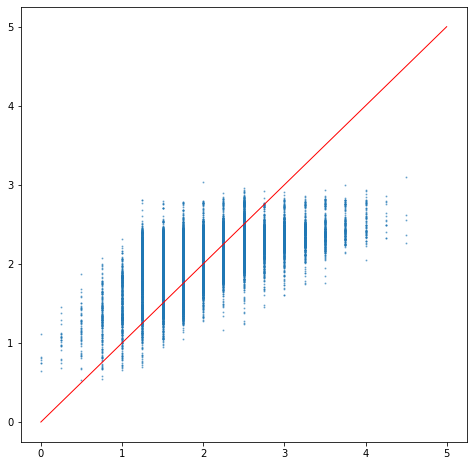

In [41]:
# Pred plot
user_ids = ratings_test.cust.values
pd_ids = ratings_test.pd_c.values
user_test = test_asz
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu


plt.figure(figsize=(8,8))
plt.scatter(x = ratings_test.score, y = predictions, s=1, alpha = 0.5)
plt.plot([0, 5], [0, 5], color="red", lw=1, linestyle='solid')
plt.savefig(aa+'_test_predplot.png')

# OUTPUT file 생성

In [42]:
last["pred_score"] = keras_model_best.predict([last["cust"], last["pd_c"], last["ages"], last["ma_fem_dv"]]) + mu

In [43]:
last

,cust,pd_c,ages,ma_fem_dv,pred_score
0,0,0,40.0,1,1.987754
1,0,1,40.0,1,1.937155
2,0,2,40.0,1,1.973925
3,0,3,40.0,1,1.791921
4,0,4,40.0,1,1.811661
...,...,...,...,...,...
29410703,20276,1460,50.0,1,1.965976
29410704,20276,1461,50.0,1,1.917952
29410705,20276,1462,50.0,1,1.995729
29410706,20276,1463,50.0,1,1.814395


In [44]:
last.to_csv(aa+"_output.csv",index=False)